In [8]:
import warnings
warnings.filterwarnings('ignore')

In [108]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from arch import arch_model
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.optimize import minimize

In [39]:
df = pd.read_csv('price_data.csv')
df = df.fillna(40.302841)
df = df.set_index('Date',drop = True).astype('float')
df.index = pd.to_datetime(df.index)
pct_change = df.apply(lambda x: x.pct_change()).iloc[1:,:]
pct_change = pct_change.iloc[:,0:5] 

In [40]:
#The stocks
pct_change.columns

Index(['MMM', 'AXP', 'AAPL', 'BA', 'CAT'], dtype='object')

### Check Stationary

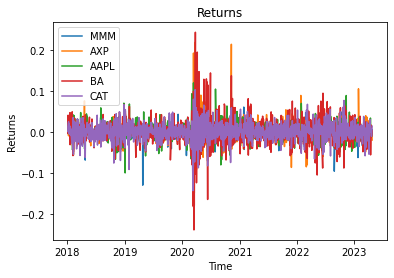

In [41]:
for column in pct_change.columns:
    plt.plot(pct_change[column], label=column)

# Set the plot title and labels
plt.title('Returns')
plt.xlabel('Time')
plt.ylabel('Returns')

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [42]:
train = pct_change[pct_change.index.year < 2021]
test = pct_change[pct_change.index.year >= 2021]

In [43]:
print("length of training set:",len(train))
print("length of testing set:",len(test))

length of training set: 755
length of testing set: 580


### Mean Modelling of Stocks Return

AR and MA orders: 0 1
                               SARIMAX Results                                
Dep. Variable:                    MMM   No. Observations:                  755
Model:                 ARIMA(0, 0, 1)   Log Likelihood                1941.723
Date:                Tue, 16 May 2023   AIC                          -3877.447
Time:                        16:35:37   BIC                          -3863.567
Sample:                             0   HQIC                         -3872.100
                                - 755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.849e-05      0.001     -0.144      0.886      -0.001       0.001
ma.L1         -0.0553      0.024     -2.320      0.020      -0.102      -0.009
sigma2         0.0003   8.29e-

AR and MA orders: 0 1
                               SARIMAX Results                                
Dep. Variable:                    CAT   No. Observations:                  755
Model:                 ARIMA(0, 0, 1)   Log Likelihood                1797.397
Date:                Tue, 16 May 2023   AIC                          -3588.794
Time:                        16:35:49   BIC                          -3574.913
Sample:                             0   HQIC                         -3583.447
                                - 755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.687      0.492      -0.001       0.002
ma.L1         -0.0556      0.027     -2.042      0.041      -0.109      -0.002
sigma2         0.0005   1.53e-

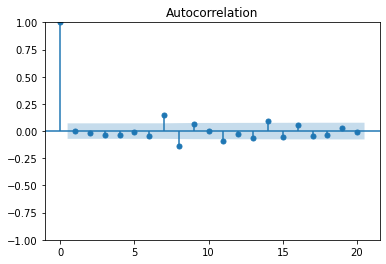

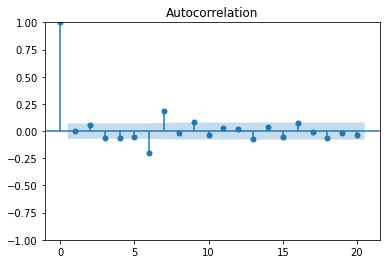

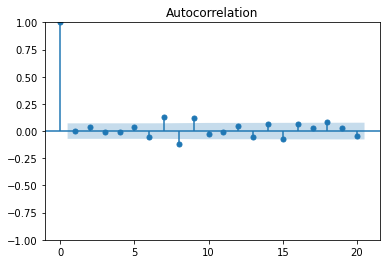

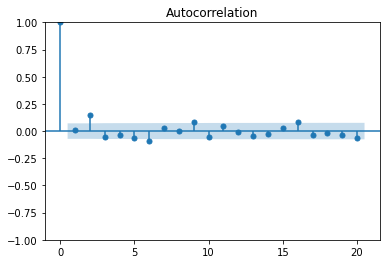

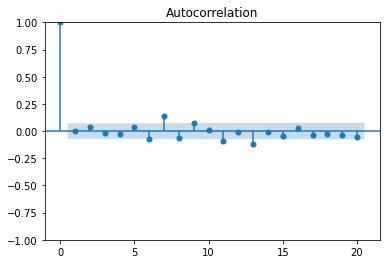

In [96]:
arma_forecasts = pd.DataFrame()
garch_forecasts = pd.DataFrame()


for stock in train.columns:
    train_returns = train[stock]
    test_returns = test[stock]
    # ARIMA
    order = sm.tsa.arma_order_select_ic(returns, ic='aic')['aic_min_order']
    ar_order, ma_order = order[0], order[1]
    print('AR and MA orders:',ar_order, ma_order)

    arma_model = sm.tsa.ARIMA(train_returns, order=(ar_order, 0, ma_order))
    arma_result = arma_model.fit()
    print(arma_result.summary())

    # Residual analysis
    residuals = arma_result.resid

    # Residual correlogram
    sm.graphics.tsa.plot_acf(residuals, lags=20)
    
    # Step 4: Compute ARMA residuals on the train set
    arma_residuals = arma_result.resid

    # Step 5: Estimate multivariate GARCH model on the train set
    garch_model = arch_model(arma_residuals, vol='Garch', p=1, q=1)
    garch_result = garch_model.fit()

    # Step 6: Generate forecasts on the test set
    arma_forecast = arma_result.forecast(steps=1).tolist()
    garch_forecast = np.sqrt(garch_result.forecast(horizon=1).variance.values[-1, :])
    
    arma_forecasts[stock] = arma_forecast
    garch_forecasts[stock] = garch_forecast


In [97]:
print(arma_forecasts)

        MMM       AXP      AAPL        BA       CAT
0 -0.000324 -0.000717  0.003582 -0.000728 -0.000087


In [98]:
print(garch_forecasts)

        MMM      AXP      AAPL        BA       CAT
0  0.014144  0.01308  0.018266  0.020216  0.014865


### Compute evaluation metrics to assess the accuracy of the forecasts. 

In [99]:
actual_vol = np.sqrt(np.mean(test ** 2))
actual_vol

MMM     0.014960
AXP     0.020199
AAPL    0.018896
BA      0.025361
CAT     0.018690
dtype: float64

In [104]:
actual_returns = test.iloc[0]
actual_returns

MMM    -0.016706
AXP    -0.023737
AAPL   -0.024719
BA     -0.052976
CAT     0.000714
Name: 2021-01-04 00:00:00, dtype: float64

In [106]:
def evaluate_forecasts(actual, forecasts):
    mae = np.mean(np.abs(forecasts - actual))
    rmse = np.sqrt(np.mean((forecasts - actual) ** 2))
    return mae, rmse

arma_mae, arma_rmse = evaluate_forecasts(actual_returns, arma_forecasts)
garch_mae, garch_rmse = evaluate_forecasts(actual_vol, garch_forecasts)

In [107]:
print("ARMA Evaluation Metrics:")
print("MAE:", arma_mae)
print("RMSE:", arma_rmse)

print("GARCH Evaluation Metrics:")
print("MAE:", garch_mae)
print("RMSE:", garch_rmse)


ARMA Evaluation Metrics:
MAE: MMM     0.016382
AXP     0.023019
AAPL    0.028301
BA      0.052248
CAT     0.000801
dtype: float64
RMSE: MMM     0.016382
AXP     0.023019
AAPL    0.028301
BA      0.052248
CAT     0.000801
dtype: float64
GARCH Evaluation Metrics:
MAE: MMM     0.000816
AXP     0.007118
AAPL    0.000629
BA      0.005145
CAT     0.003825
dtype: float64
RMSE: MMM     0.000816
AXP     0.007118
AAPL    0.000629
BA      0.005145
CAT     0.003825
dtype: float64


In [242]:
expected_returns = arma_forecasts.T.values
covariance_matrix = garch_forecasts.T@garch_forecasts.values

sample_mean = train.mean().values.reshape((5,1))
sample_cov = train.cov().values

In [243]:
target = 0.3/12
r = 0.002

In [254]:
def constrainedMV(d,sigma,mu):
    initial_weight = np.abs(np.random.randn(d))
    x0 = initial_weight/np.sum(initial_weight)
    x0 = x0.reshape((5,1))
    cons = ({'type': 'eq', 'fun': lambda x: r + np.dot(x,mu-r) - target },
            {'type': 'ineq', 'fun': lambda x:x },
            {'type': 'eq', 'fun': lambda x: 1-np.sum(x)})

    res = minimize(func, x0,args = (sigma),constraints=cons )
    return np.array(res.x)

def func(x,sigma):
    return np.dot(np.dot(x,sigma),x)

In [255]:
def mean_variance(expected_returns,covariance_matrix):
    mu = expected_returns
    sigma = covariance_matrix
    aa = constrainedMV(5,sigma,mu)

    return aa

In [260]:
# Perform portfolio optimization using ARMA-GARCH estimates
ts_AA  = mean_variance(expected_returns,covariance_matrix).reshape((5,1))

# Perform portfolio optimization using sample mean and variance
sample_AA  = mean_variance(sample_mean,sample_cov).reshape((5,1))

In [264]:
# Calculate the one-step ahead optimized portfolio returns
arma_optimized_portfolio_returns = np.dot(expected_returns.T, ts_AA)
sample_optimized_portfolio_returns = np.dot(sample_mean.T, sample_AA)

# Calculate the one-step ahead optimized portfolio variance using ARMA-GARCH covariance matrix
arma_optimized_portfolio_variance = np.dot(ts_AA.T, np.dot(covariance_matrix, ts_AA))

# Calculate the one-step ahead optimized portfolio variance using sample covariance matrix
sample_optimized_portfolio_variance = np.dot(sample_AA.T, np.dot(sample_cov, sample_AA))

# Calculate the one-step ahead optimized portfolio standard deviation
arma_optimized_portfolio_std_dev = np.sqrt(arma_optimized_portfolio_variance)
sample_optimized_portfolio_std_dev = np.sqrt(sample_optimized_portfolio_variance)


In [266]:
# Print the results
print("ARMA-GARCH Model:")
print("Optimized Weights:", ts_AA)
print("Expected Return:", np.mean(arma_optimized_portfolio_returns))
print("Standard Deviation:", arma_optimized_portfolio_std_dev)
print()
print("Sample Mean-Variance Model:")
print("Optimized Weights:", sample_AA)
print("Expected Return:", np.mean(sample_optimized_portfolio_returns))
print("Standard Deviation:", sample_optimized_portfolio_std_dev)

ARMA-GARCH Model:
Optimized Weights: [[-1.72297130e-13]
 [-7.62613709e-13]
 [ 1.00000000e+00]
 [-3.37573804e-13]
 [-1.54301882e-13]]
Expected Return: 0.0035816046125769388
Standard Deviation: [[0.0182664]]

Sample Mean-Variance Model:
Optimized Weights: [[-2.58019831e-13]
 [-1.15407236e-13]
 [ 1.00000000e+00]
 [-2.36905116e-14]
 [-1.20097656e-13]]
Expected Return: 0.0017872197399597185
Standard Deviation: [[0.02211245]]
